# Predicción

In [1]:
#Paquetes y Librerias
import snowflake.connector as sf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import re
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
pd.set_option('mode.chained_assignment', None)

In [2]:
session = tf.Session()

In [3]:
%run '../Config/Config.py'
Config = np.array(para())

In [4]:
conn = sf.connect(user = Config[0], password = Config[1], account = Config[2], role= Config[3], database =Config[4])

In [5]:
def execute_query (connection, query):
    cursor = connection.cursor()
    cursor.execute(query)
    cursor.close()

In [6]:
try:
    sql = 'use {}'.format(Config[4])
    execute_query(conn,sql)

    sql = 'use warehouse {}'.format(Config[5])
    execute_query(conn,sql)
    
    sql = open('../DataSet/Train.txt')
    sql = sql.read()
    
    cursor = conn.cursor()
    cursor.execute(sql)

    Train = []
    for c in cursor:
        Train.append(c)
                      
                  
except Exception as e:
    print(e)

In [7]:
train = pd.DataFrame(Train)

In [8]:
train.iloc[:, 20:21] = train.iloc[:, 20:21].fillna(False)
train.iloc[:, 6:7] = train.iloc[:, 6:7].fillna("Sin Definir")
train.iloc[:, 21:22] = train.iloc[:, 21:22].fillna(0)
train.iloc[:, 1] = pd.to_datetime(train.iloc[:, 1])
train.iloc[:, 1]= train.iloc[:, 1].apply(lambda x: x.toordinal())

In [9]:
#Definir los valores de entrenamiento y de prediccion.
x = train.iloc[:, [0,1, 5, 6, 8, 10, 14, 15, 19, 20, 21]].values
y = train.iloc[:, [0,22]].values

In [10]:
#Limpiar los datos
imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer = imputer.fit(x[:, [1, 2, 4, 5, 6, 7, 8, 10]])
x[:, [1, 2, 4, 5, 6, 7, 8, 10]] = imputer.transform(x[:, [1, 2, 4, 5, 6, 7, 8, 10]])

In [11]:
#Codificar los datos
labelecoder_x = LabelEncoder()
x[:, 9] = labelecoder_x.fit_transform(x[:,9])
onehotencoder = make_column_transformer((OneHotEncoder(sparse=False), [3]), remainder="passthrough")
x = onehotencoder.fit_transform(x)

In [12]:
#Separar los Datos de train y test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [13]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [14]:
sc_X = StandardScaler()
X_train.loc[:, X_train.columns != 68] = sc_X.fit_transform(X_train.loc[:, X_train.columns != 68])
X_test.loc[:, X_test.columns != 68]= sc_X.transform(X_test.loc[:, X_test.columns != 68])

### Modelo de regresión logística

- $x$
- $A$
- $b$
- $y = Ax+b$
- $\hat{y} = sigmoid(y)$

In [15]:
batch_size = 25
x_data = tf.placeholder(shape=[None, 77], dtype = tf.float32)
y_target = tf.placeholder(shape = [None, 1], dtype=tf.float32)
A = tf.Variable(tf.random_normal(shape=[77,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))
y_pred = tf.add(tf.matmul(x_data, A), b)

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred, labels= y_target))
pred = tf.nn.sigmoid_cross_entropy_with_logits(logits= y_pred, labels=y_target)
init = tf.global_variables_initializer()
session.run(init)
my_optim = tf.train.GradientDescentOptimizer(learning_rate=0.25)
train_step = my_optim.minimize(loss)

In [17]:
classification_lr = tf.round(tf.sigmoid(y_pred))
correct_classification = tf.cast(tf.equal(classification_lr, y_target), tf.float32)
accuracy = tf.reduce_mean(correct_classification)

In [18]:
loss_vec = []
train_acc = []
test_acc = []
prediction = []
predictionTest = []

for i in range(1000):
    rand_idx = np.random.choice(len(X_train), size=batch_size)
    rand_x = X_train.loc[rand_idx]
    rand_y = np.transpose([y_train[rand_idx,1]])
    session.run(train_step, feed_dict={x_data: rand_x.loc[:, rand_x.columns != 68], y_target: rand_y})
    temp_loss = session.run(loss, feed_dict={x_data: rand_x.loc[:, rand_x.columns != 68], y_target: rand_y})
    loss_vec.append(temp_loss)
    
    temp_acc_train = session.run(accuracy, 
                                 feed_dict={x_data: X_train.loc[:, X_train.columns != 68], y_target: np.transpose([y_train[:,1]])})
    train_acc.append(temp_acc_train)
    temp_acc_test = session.run(accuracy, 
                                feed_dict={x_data: X_test.loc[:, X_test.columns != 68], y_target: np.transpose([y_test[:,1]])})
    test_acc.append(temp_acc_test)
    
    temp_pred=session.run(classification_lr,feed_dict={x_data: X_train.loc[:, X_train.columns != 68]})
    prediction =temp_pred
    
    temp_predtest=session.run(classification_lr,feed_dict={x_data: X_test.loc[:,X_test.columns !=68]})
    predictionTest = temp_predtest
     
    if(i+1)%100==0:
        print("Loss: "+str(temp_loss)+ " Acc: "+ str(temp_acc_train)+ " AccTest: "+str(temp_acc_test))
      
    

Loss: 0.0382612 Acc: 0.98887414 AccTest: 0.9889964
Loss: 0.021060104 Acc: 0.9931068 AccTest: 0.9938331
Loss: 0.013403991 Acc: 0.9976116 AccTest: 0.9978235
Loss: 0.009385545 Acc: 0.99785346 AccTest: 0.99794436
Loss: 0.007823481 Acc: 0.99806505 AccTest: 0.99794436
Loss: 0.0068172645 Acc: 0.9985186 AccTest: 0.9987908
Loss: 0.008336936 Acc: 0.9984883 AccTest: 0.9987908
Loss: 0.003956841 Acc: 0.9985186 AccTest: 0.9987908
Loss: 0.0052044946 Acc: 0.99903256 AccTest: 0.99891174
Loss: 0.0043939007 Acc: 0.99915344 AccTest: 0.99891174


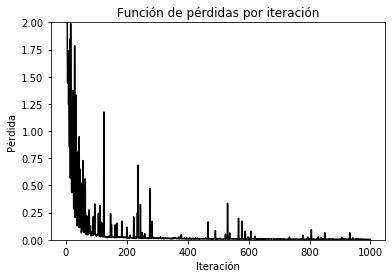

In [19]:
plt.plot(loss_vec, 'k-')
plt.title("Función de pérdidas por iteración")
plt.xlabel("Iteración")
plt.ylabel("Pérdida")
plt.ylim([0,2])
plt.show()

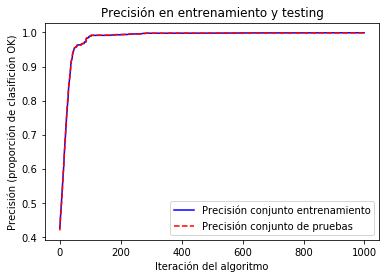

In [20]:
plt.plot(train_acc, 'b-', label = "Precisión conjunto entrenamiento")
plt.plot(test_acc, 'r--', label = "Precisión conjunto de pruebas")
plt.title("Precisión en entrenamiento y testing")
plt.xlabel("Iteración del algoritmo")
plt.ylabel("Precisión (proporción de clasifición OK)")
plt.legend(loc = 'lower right')
plt.show()

In [21]:
ResultPred = pd.DataFrame(prediction)
ResultPredTest = pd.DataFrame(predictionTest)

In [22]:
DataPredTrain = X_train.loc[:,[68]]
DataPredTest = X_test.loc[:,[68]]
DataPredTrain[1] = ResultPred
DataPredTest[1] = ResultPredTest

In [23]:
DataPredTrain.loc[DataPredTrain[68].isin(['5cc37d827cec42002b08a764',
'5ccba9345de703002bc3c2c8',
'5ccc520ac791b50046687294',
'5cccb879424ffe0040d54ae3',
'5ccceae8424ffe0025d59bbc',
'5ccda264f41acf0040b73899',
'5cd15a024a618f001697f9a3',
'5cd185b74c8daa0043c06857',
'5cd1d6b24a618f001398c458',
'5cd2ebae70819e4aff81c14a',
'5cd34546734f770043917d5b',
'5cd42bf4734f7700199284d2',
'5cd489cfc0aad7005e186f45',
'5cd4a987c0aad70016188c72',
'5cd56d14c0aad70034196b1e',
'5cd5db643911930037189854',
'5cd6261f1e0ab9000d3987fd',
'5cd7d6f1d4476000136279e1',
'5cd84fe7b7c305002ba83fb3',
'5cdabd1b2cd44300619a62d6',
'5cf161f63eea2d004cceee3c',
'5cf1741888e702003a727401',
'5cf1b69f68bf5d00584bff7b',
'5cf1c7ac88e702002872a223',
'5cf1dbdb88e702003a72af24',
'5cf3301198dbd1002e022101',
'5cf6db4f7be3130058eabfe7',
'5cf7e3415eef8e000ad97d0b',
'5d1705ad2b7b8d001768f60d',
'5d1fe40f1b2fb6123ec6be53',
'5d29215d923f58002063a3c7',
'5d29fec6923f58001163ff45',
'5d2de9d767af2c2a3be229ee',
'5d30d55cfa03470053ecb4fa',
'5d3c450bc8fe5c002f6f6f57',
'5d4838e5432aa9003367f569',
'5d49ed794890890060366c4f',
'5d4cb8bca8fc2700605c2721'])]

,68,1
821,5cd2ebae70819e4aff81c14a,1.0
1853,5cf7e3415eef8e000ad97d0b,1.0
1941,5cd1d6b24a618f001398c458,1.0
5151,5cd7d6f1d4476000136279e1,1.0
5565,5ccceae8424ffe0025d59bbc,1.0
6880,5d1705ad2b7b8d001768f60d,0.0
7328,5cd185b74c8daa0043c06857,1.0
9246,5d1fe40f1b2fb6123ec6be53,1.0
9272,5cd42bf4734f7700199284d2,1.0
11796,5cd34546734f770043917d5b,1.0


- 29 datos de train, predicciones = 23

In [24]:
DataPredTest.loc[DataPredTest[68].isin([
'5cc37d827cec42002b08a764',
'5ccba9345de703002bc3c2c8',
'5ccc520ac791b50046687294',
'5cccb879424ffe0040d54ae3',
'5ccceae8424ffe0025d59bbc',
'5ccda264f41acf0040b73899',
'5cd15a024a618f001697f9a3',
'5cd185b74c8daa0043c06857',
'5cd1d6b24a618f001398c458',
'5cd2ebae70819e4aff81c14a',
'5cd34546734f770043917d5b',
'5cd42bf4734f7700199284d2',
'5cd489cfc0aad7005e186f45',
'5cd4a987c0aad70016188c72',
'5cd56d14c0aad70034196b1e',
'5cd5db643911930037189854',
'5cd6261f1e0ab9000d3987fd',
'5cd7d6f1d4476000136279e1',
'5cd84fe7b7c305002ba83fb3',
'5cdabd1b2cd44300619a62d6',
'5cf161f63eea2d004cceee3c',
'5cf1741888e702003a727401',
'5cf1b69f68bf5d00584bff7b',
'5cf1c7ac88e702002872a223',
'5cf1dbdb88e702003a72af24',
'5cf3301198dbd1002e022101',
'5cf6db4f7be3130058eabfe7',
'5cf7e3415eef8e000ad97d0b',
'5d1705ad2b7b8d001768f60d',
'5d1fe40f1b2fb6123ec6be53',
'5d29215d923f58002063a3c7',
'5d29fec6923f58001163ff45',
'5d2de9d767af2c2a3be229ee',
'5d30d55cfa03470053ecb4fa',
'5d3c450bc8fe5c002f6f6f57',
'5d4838e5432aa9003367f569',
'5d49ed794890890060366c4f',
'5d4cb8bca8fc2700605c2721'])]

,68,1
699,5cf1c7ac88e702002872a223,1.0
1326,5cf1dbdb88e702003a72af24,0.0
3726,5d3c450bc8fe5c002f6f6f57,0.0
4599,5d4cb8bca8fc2700605c2721,0.0
5675,5cdabd1b2cd44300619a62d6,1.0
5887,5cc37d827cec42002b08a764,1.0
6313,5cf6db4f7be3130058eabfe7,1.0
6401,5cf1b69f68bf5d00584bff7b,1.0
6450,5cd5db643911930037189854,1.0


 - Datos de Test 5, predicciones 5